In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_smoothed, fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            raw_smoothed, interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object
            self.fictrac[short] = raw_smoothed

    def make_walking_vector(self):
        self.fictrac['W'] = np.zeros(len(self.fictrac['Y']))
        YZ = np.sqrt(np.power(self.fictrac['Y']/np.std(self.fictrac['Y']),2),
             np.power(self.fictrac['Z']/np.std(self.fictrac['Z']),2))
        self.fictrac['W'][np.where(YZ>.2)] = 1

        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)
        self.fictrac['Wi'] = interp1d(x_original, self.fictrac['W'], bounds_error = False, kind = 'nearest')

In [5]:
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()
    flies[fly].fictrac.make_walking_vector()


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.39 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.00 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 2.89 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.11 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 2.62 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.00 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 2.74 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.10 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 2.59 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.02 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 2.33 ms

~

In [11]:
#width = 120000 #in ms, 2min
width = 60000 #in ms
width = 20000 #in ms


step = 500 #in ms
time_shifts = list(range(-width,width,step))
xs = np.asarray(time_shifts)/1000

In [12]:
185, 77, 227, 141, 186 #very early inhibition
93,  27, 240, 116, 106, 204 #very early excititation

(93, 27, 240, 116, 106, 204)

In [13]:
behavior_i = 'Zi'
z=25

all_behavior_shifts = []
for fly in fly_names:
    interp_obj = flies[fly].fictrac.fictrac[behavior_i]
    behavior_shifts = []
    for shift in time_shifts:
        fictrac_interp = interp_obj(flies[fly].timestamps[:,z]+shift)
        fictrac_interp = np.nan_to_num(fictrac_interp)
        behavior_shifts.append(fictrac_interp)
    all_behavior_shifts.append(np.asarray(behavior_shifts))
all_behavior_shifts = np.asarray(all_behavior_shifts)

X = np.reshape(np.moveaxis(all_behavior_shifts,0,1),(-1,30456))
X.shape

(80, 30456)

In [16]:
cluster = 77
Y = supercluster_signals[cluster,:]
cluster_response_77_L = np.dot(np.clip(X,0,None),Y)
cluster_response_77_R = np.dot(np.clip(X,None,0)*-1,Y)

cluster += 250
Y = supercluster_signals[cluster,:]
cluster_response_327_L = np.dot(np.clip(X,0,None),Y)
cluster_response_327_R = np.dot(np.clip(X,None,0)*-1,Y)

Text(0.5, 0, 'Time (sec)')

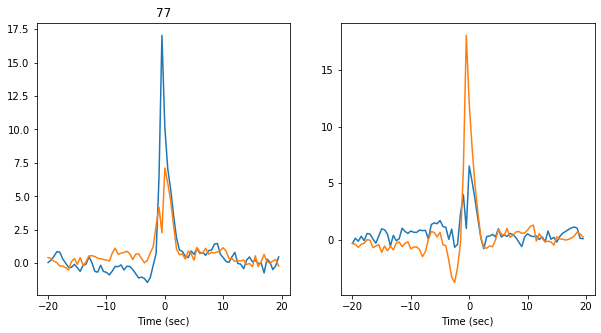

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title(cluster-250)
plt.plot(xs,cluster_response_77_L[::-1])
plt.plot(xs,cluster_response_327_L[::-1])
plt.xlabel('Time (sec)')

plt.subplot(122)
plt.plot(xs,cluster_response_77_R[::-1])
plt.plot(xs,cluster_response_327_R[::-1])
plt.xlabel('Time (sec)')

In [18]:
### calculate for all clusters

cluster_response_LB_LT = [] #LeftBrain, LeftTurn...
cluster_response_LB_RT = []

cluster_response_RB_LT = []
cluster_response_RB_RT = []

for cluster in range(250):
    Y = supercluster_signals[cluster,:]
    cluster_response_LB_LT.append(np.dot(np.clip(X,0,None),Y))
    cluster_response_LB_RT.append(np.dot(np.clip(X,None,0)*-1,Y))

    cluster += 250
    Y = supercluster_signals[cluster,:]
    cluster_response_RB_LT.append(np.dot(np.clip(X,0,None),Y))
    cluster_response_RB_RT.append(np.dot(np.clip(X,None,0)*-1,Y))

In [23]:
cluster_response_LB_LT = np.asarray(cluster_response_LB_LT)
cluster_response_LB_RT = np.asarray(cluster_response_LB_RT)
cluster_response_RB_LT = np.asarray(cluster_response_RB_LT)
cluster_response_RB_RT = np.asarray(cluster_response_RB_RT)

In [24]:
cluster_response_LB_LT.shape

(250, 80)

In [25]:
# for movie lets show the average for both turns

cluster_response_ipsi = (cluster_response_LB_LT + cluster_response_RB_RT) / 2
cluster_response_contra = (cluster_response_LB_RT + cluster_response_RB_LT) / 2
cluster_response_diff = cluster_response_ipsi - cluster_response_contra

In [28]:
cluster_response_diff = cluster_response_diff[:,::-1]

In [51]:
#SC to remove due to bad agreement across turns etc
#20230208 - map spread of asymmetry during turn

to_remove = np.array([  0,   3,   8,  13,  15,  20,  23,  24,  28,  29,  31,  33,  35,
         36,  37,  41,  42,  44,  45,  46,  48,  49,  50,  53,  55,  56,
         58,  59,  61,  64,  67,  68,  70,  74,  75,  79,  81,  83,  87,
         92,  96,  97,  98,  99, 100, 105, 107, 108, 114, 118, 120, 124,
        125, 127, 128, 130, 131, 132, 133, 136, 137, 139, 140, 145, 148,
        153, 155, 160, 161, 164, 167, 168, 169, 170, 171, 174, 177, 181,
        183, 184, 190, 191, 192, 193, 194, 196, 197, 202, 205, 207, 208,
        209, 210, 211, 214, 217, 218, 220, 221, 222, 230, 231, 234, 235,
        236, 238, 241, 242, 243, 244])

In [57]:
cluster_response_diff_smooth = gaussian_filter1d(cluster_response_diff,sigma=1,truncate=1,axis=1)

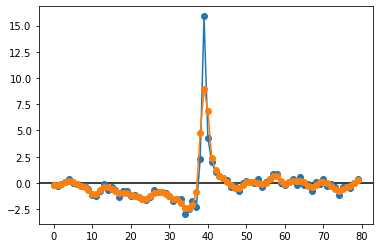

In [59]:
plt.axhline(0,color='k')
plt.plot(cluster_response_diff[77,:],marker='o')
plt.plot(cluster_response_diff_smooth[77,:],marker='o')

In [60]:
#remove bad clusters

for cluster in range(250):
    if cluster in to_remove:
        cluster_response_diff_smooth[cluster,:] = 0

In [19]:
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [20]:
### lets visualize these high ipsi low contra on brain
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [61]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20230301_movied'
os.mkdir(save_path)

In [62]:
for k,tp in enumerate(tqdm.tqdm(range(80))):

    ### color brain by peak time
    brain = np.zeros((314, 146, 91))
    for cluster in range(250):
        ind = np.where(superclusters_250==cluster)
        brain[ind[0],ind[1],ind[2]] = cluster_response_diff_smooth[cluster,tp]

    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = brain
    vmax = 5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(explosion_map[150:,:])
    plt.axis('off')
    plt.title(F"{xs[k]} sec")
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    fig.clf()

100%|██████████| 80/80 [10:36<00:00,  7.96s/it]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>